# NLP With Disaster Tweets

## Brief Description of The Problem and Data

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter(i.e. disaster relief organizations and news agencies).
The task is to build a model that can classify tweets as either related to a real disaster or not. This is a common natural language processing (NLP) problem involving text classification.

## Data Overview

This dataset is from https://www.kaggle.com/competitions/nlp-getting-started/data, include 7613 rows of tweets for training, 3263 rows of tweets for testing.

The dataset consists of:

train.csv: Training data with columns:
id: Unique identifier for each tweet
text: The tweet content
location: The location from where the tweet was sent (optional)
keyword: A specific keyword from the tweet (optional)
target: Binary label indicating if the tweet is about a real disaster (1) or not (0)

test.csv: Test data similar to train.csv but without the target column.


In [ ]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import subprocess
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
# Tensorflow libraries updated to work with vs code
tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Dense, Dropout 
from tensorflow.python.keras.layers.recurrent import LSTM
bi_directional = tf.keras.layers.Bidirectional
batch_normalization = tf.keras.layers.BatchNormalization
from tensorflow.python.keras.regularizers import l2
adam = tf.keras.optimizers.Adam
adagrad = tf.keras.optimizers.Adagrad
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
# disable ssl check for downloading some of the libraries
# https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [32]:
# download data cleaning libraries
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/judoboyalex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/judoboyalex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/judoboyalex/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/judoboyalex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [24]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [25]:
print(train_data.head())

   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]


In [26]:
missing_values = train_data.isnull().sum()
missing_values_percentage = (missing_values / len(train_data)) * 100

missing_data_summary = pd.DataFrame({"Missing Values": missing_values, 
                                     "Percentage": missing_values_percentage})
missing_data_summary

,Missing Values,Percentage
id,0,0.000000
keyword,61,0.801261
location,2533,33.272035
text,0,0.000000
target,0,0.000000


From the data overview, only keyword and location have missing values with location having one third of the data missing.
My data cleaning process will involve:
- find a way to handle those missing values.
- clean up text from punctuations, emoji and url to prepare the data to be used for model.

Let's visualize the data.

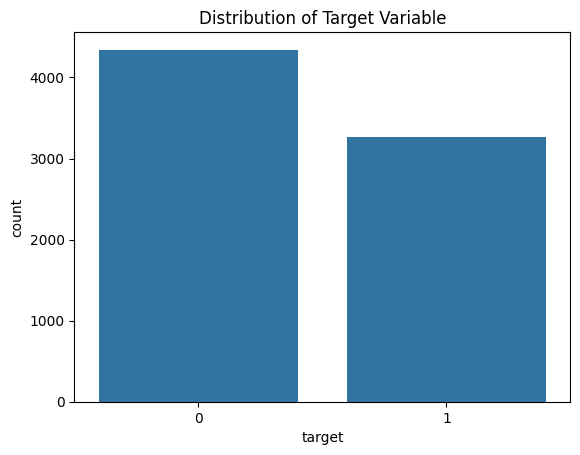

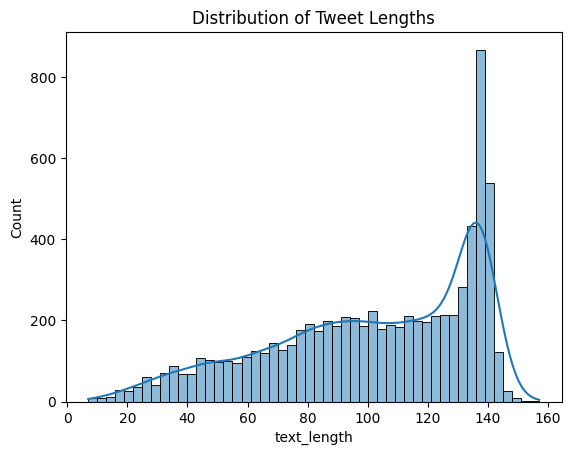

In [27]:
# Plot the distribution of the target variable
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.show()

# Plot the length of tweets
train_data['text_length'] = train_data['text'].apply(len)
sns.histplot(train_data['text_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.show()

Nothing significant can be extracted from this visualization as these datas are expected from tweets.

Now let's clean up the text.

### Text Preprocessing



In [ ]:
# list of emojis to delete
emojis = ["\U0001F600", "\U0001F64F", "\U0001F300", "\U0001F5FF", "\U0001F680", "\U0001F6FF",
          "\U0001F1E0", "\U0001F1FF", "\U00002702", "\U000027B0", "\U000024C2", "\U0001F251"]

def preprocess_text(text):
    text = text.lower()

    for emoji in emojis:
        text = text.replace(emoji, "")

    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # delete urls
    text = re.sub(r'@\w+', '', text) # all texts starting @ are removed
    text = re.sub(r'[^\w\s]', '', text) # remove any special characters

    tokenizer = RegexpTokenizer(r"\w+")
    tokens = tokenizer.tokenize(text)

    stopWords = nltk.corpus.stopwords.words("english")
    tokens = [word for word in tokens if word not in stopWords]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]


    tokens = [word for word in tokens if not word.isdigit()]

    tokens = [word for word in tokens if len(word) > 1]

    return ' '.join(tokens)


train_data['preprocessed_text'] = train_data['text'].apply(preprocess_text)
train_data['preprocessed_text'].head()

0             deed reason earthquake may allah forgive
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: preprocessed_text, dtype: object

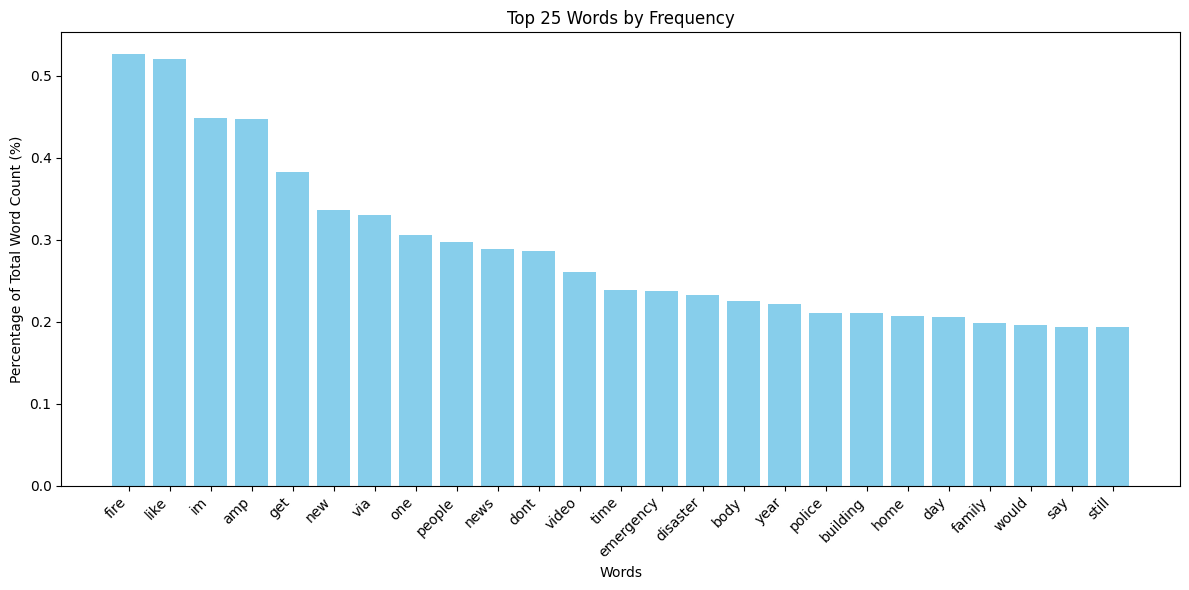

In [36]:
# Plot top 25 words by frequency
frequency = train_data['preprocessed_text'].str.split(expand=True).unstack().value_counts()
freqplot = frequency[:25] / np.sum(frequency) * 100

plt.figure(figsize=(12, 6))
plt.bar(freqplot.index, freqplot.values, color='skyblue')
plt.title('Top 25 Words by Frequency')
plt.xlabel('Words')
plt.ylabel('Percentage of Total Word Count (%)')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()